<a href="https://colab.research.google.com/github/tatsath/Interpretability/blob/main/Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision Trees with Features

This notebook demonstrates how to build a simple, interpretable classifier using SAE feature activations for sentiment analysis of financial news. The model classifies articles into positive, neutral, and negative sentiment categories.

Preliminary results indicate that these activation-based classifiers may provide advantages in both speed and cost when compared to few-shot prompting and fine-tuning approaches. They also show potential for better cross-dataset generalization than their fine-tuned counterparts.

In [ ]:
!pip install goodfire

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 47.9 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
  Attempting uninstall: httpx
    Found existing installation: httpx 0.28.1
    Uninstalling httpx-0.28.1:
      Successfully uninstalled httpx-0.28.1
  Attempting uninstall: 

In [ ]:
from google.colab import userdata

# Add your Goodfire API Key to your Colab secrets
GOODFIRE_API_KEY = userdata.get("GOODFIRE_API_KEY")

## Setup

### Initialize the SDK

In [ ]:
import goodfire

client = goodfire.Client(api_key=GOODFIRE_API_KEY)

### Import the classification data

In this example, we use the [ChanceFocus/flare-finqa](https://huggingface.co/datasets/ChanceFocus/flare-finqa) dataset.

In [ ]:
import pandas as pd

splits = {
    "train": "data/train-00000-of-00001-ab9a3b4799b09589.parquet",
    "test": "data/test-00000-of-00001-8bd1e21c671fb670.parquet",
    "valid": "data/valid-00000-of-00001-303e4ba2afe838d4.parquet",
}
df = pd.read_parquet("hf://datasets/ChanceFocus/en-fpb/" + splits["train"])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
df

,id,query,answer,text,choices,gold
0,fpb0,Analyze the sentiment of this statement extrac...,neutral,"The five-storey , eco-efficient building will ...","[positive, neutral, negative]",1
1,fpb1,Analyze the sentiment of this statement extrac...,positive,"According to Sepp+ñnen , the new technology UM...","[positive, neutral, negative]",0
2,fpb2,Analyze the sentiment of this statement extrac...,negative,"The currency effect had a 3.0 pct , or 20 mln ...","[positive, neutral, negative]",2
3,fpb3,Analyze the sentiment of this statement extrac...,positive,`` We have analyzed Kaupthing Bank Sweden and ...,"[positive, neutral, negative]",0
4,fpb4,Analyze the sentiment of this statement extrac...,neutral,"For the purposes of the possible acquisition ,...","[positive, neutral, negative]",1
...,...,...,...,...,...,...
3095,fpb3095,Analyze the sentiment of this statement extrac...,negative,The announcement comes two weeks before a key ...,"[positive, neutral, negative]",2
3096,fpb3096,Analyze the sentiment of this statement extrac...,negative,Operating profit fell to EUR 6.2 mn from EUR 8...,"[positive, neutral, negative]",2
3097,fpb3097,Analyze the sentiment of this statement extrac...,positive,Cargo volume grew by 7 % .,"[positive, neutral, negative]",0
3098,fpb3098,Analyze the sentiment of this statement extrac...,neutral,Nokia said the outcome was a `` fair and respo...,"[positive, neutral, negative]",1


## Get relevant feature activations for the classification task

### Extract features for each input class

In [ ]:
# Instantiate a Goodfire variant model using "meta-llama/Meta-Llama-3.1-8B-Instruct"
variant = goodfire.Variant("meta-llama/Meta-Llama-3.1-8B-Instruct")

In [ ]:
shuffled_df = df.sample(frac=1, random_state=42)
positive_examples = shuffled_df[shuffled_df["answer"] == "positive"]
negative_examples = shuffled_df[shuffled_df["answer"] == "negative"]
neutral_examples = shuffled_df[shuffled_df["answer"] == "neutral"]

FEATURE_COMPUTE_SIZE = 60
CLASSIFIER_FULL_SET_SIZE = 150

Using the [`contrast`](https://docs.goodfire.ai/sdk-reference/features#contrast) and [`rerank`](https://docs.goodfire.ai/sdk-reference/features#rerank) endpoint, we surface SAE features that are most relevant to positive and negative class labels.

In [ ]:
positive_news_features, negative_news_features = client.features.contrast(
    dataset_1=[
        [
            {
                "role": "user",
                "content": f"Is the following good or bad news for investors? {text}",
            },
            {"role": "assistant", "content": "good"},
        ]
        for text in positive_examples[0:FEATURE_COMPUTE_SIZE]["text"].tolist()
    ],
    dataset_2=[
        [
            {
                "role": "user",
                "content": f"Is the following good or bad news for investors? {text}",
            },
            {"role": "assistant", "content": "bad"},
        ]
        for text in negative_examples[0:FEATURE_COMPUTE_SIZE]["text"].tolist()
    ],
    model=variant,
    top_k=100,
)

# Rerank the contrastive features for relevance to financial market sentiment
positive_news_features = client.features.rerank(
    features=positive_news_features,
    query="bull market",
    model=variant,
    top_k=50
)
negative_news_features = client.features.rerank(
    features=negative_news_features,
    query="bear market",
    model=variant,
    top_k=50
)
features_to_look_at = positive_news_features | negative_news_features
features_to_look_at

FeatureGroup([
   0: "Stock market ticker syntax and exchange listings",
   1: "Market demand and economic growth terminology",
   2: "Business and market growth potential in investment contexts",
   3: "Stock exchanges and securities market infrastructure",
   4: "Stock ticker symbols and financial notation",
   5: "News sentiment classification, especially for financial impacts",
   6: "Business growth and market competitiveness",
   7: "Business expansion into emerging markets",
   8: "Corporate equity ownership and share-based transactions",
   ...
   70: "Start of new conversation segment requiring ethical consistency"
])

In [ ]:
from itertools import combinations


class FeatureSearch:
    """A class for systematically searching through combinations of features to evaluate their predictive power."""

    def __init__(self, feature_group):
        self.feature_group = feature_group

    def grid(self, k_features_per_combo: int = 2):
        """Perform a grid search over all possible combinations of features.

        Args:
            k_features_per_combo (int): The number of features to include in each combination.

        Returns:
            list: All possible k-sized combinations of features from the feature group.
        """

        # Get all possible combinations of features
        return list(combinations(self.feature_group, k_features_per_combo))

### Retrieve feature activations

Using the [`inspect`](https://docs.goodfire.ai/sdk-reference/features#inspect) endpoint, we retrieve feature activations from the `features_to_look_at` FeatureGroup (defined in the previous step) for each class label.

In [ ]:
async_client = goodfire.AsyncClient(api_key=GOODFIRE_API_KEY)

In [ ]:
import pandas as pd
import asyncio
from tqdm.asyncio import tqdm_asyncio

MIN_SAMPLES_PER_CLASS = min(
    len(negative_examples),
    len(positive_examples),
    len(neutral_examples),
    CLASSIFIER_FULL_SET_SIZE,
)

async def _get_feature_acts_for_sample_class(
    sample_class: pd.DataFrame,
    features_to_use_for_classification: goodfire.FeatureGroup,
    k=100,
    batch_size=10
):
    if k < len(features_to_use_for_classification):
        raise ValueError(
            "k must be greater than the number of features to use for classification"
        )

    samples = []
    all_samples = sample_class[0:MIN_SAMPLES_PER_CLASS]

    # Process in batches
    for i in range(0, len(all_samples), batch_size):
        batch = all_samples[i:i + batch_size]
        tasks = []

        for idx, row in batch.iterrows():
            text = row["text"]
            tasks.append(
                async_client.features.inspect(
                    [
                        {
                            "role": "user",
                            "content": f"is the following good or bad for investors? {text}",
                        }
                    ],
                    model=variant,
                    features=features_to_use_for_classification,
                )
            )

        # Process this batch
        batch_results = await tqdm_asyncio.gather(*tasks)
        for context in batch_results:
            features = context.top(k=k)
            samples.append(features)

    return samples

async def process_all_classes():
    print("Computing positive news features...")
    positive_class_features = await _get_feature_acts_for_sample_class(
        positive_examples, features_to_look_at, k=100
    )

    print("Computing negative news features...")
    negative_class_features = await _get_feature_acts_for_sample_class(
        negative_examples, features_to_look_at, k=100
    )

    print("Computing neutral news features...")
    neutral_class_features = await _get_feature_acts_for_sample_class(
        neutral_examples, features_to_look_at, k=100
    )

    return positive_class_features, negative_class_features, neutral_class_features

# Run in Colab
positive_class_features, negative_class_features, neutral_class_features = await process_all_classes()

Computing positive news features...


100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


Computing negative news features...


100%|██████████| 10/10 [00:04<00:00,  2.31it/s]


Computing neutral news features...


100%|██████████| 10/10 [00:04<00:00,  2.35it/s]


## Train decision tree

This code performs an exhaustive search to find the best combination of SAE features for sentiment classification using decision trees. We evaluate different feature sets systematically, training a regularized decision tree classifier on each combination and tracking the best-performing set based on F1 score.

In [ ]:
from sklearn import tree
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, accuracy_score, f1_score
import numpy as np
import tqdm


def train_tree(x, y, depth):
    train_x, test_x, train_y, test_y = train_test_split(
        x, y, train_size=0.5, random_state=42
    )

    # Create a nice regularized tree
    model = tree.DecisionTreeClassifier(
        max_depth=depth, min_samples_leaf=len(train_x) // 10, random_state=42
    )

    model.fit(train_x, train_y)

    pred = model.predict(test_x)

    # Calculate the f1 score of the model
    score = f1_score(test_y, pred)

    return model, pred, score


def find_best_combo(features, k_features_per_combo=2):
    combos = FeatureSearch(features).grid(k_features_per_combo=k_features_per_combo)
    best_combo = None
    best_model = None
    mean_act_negative = 0
    mean_act_positive = 0
    support_vector_distances = 0
    best_score = 0

    for combo in tqdm.tqdm(combos):
        # Create a linear regression model
        def _select_feature_acts(combo, row):
            output = []
            for index, feature in enumerate(combo):
                for feature_act in row:
                    if feature_act.feature.uuid == feature.uuid:
                        output.append(feature_act.activation)
                        break

            return output

        x_negative = [
            _select_feature_acts(combo, row) for row in negative_class_features
        ]
        # x_neutral = [_select_feature_acts(combo, row) for row in neutral_class_features]
        x_positive = [
            _select_feature_acts(combo, row) for row in positive_class_features
        ]

        y_negative = [-1] * len(x_negative)
        # y_neutral = [0] * len(x_neutral)
        y_positive = [1] * len(x_positive)

        x = x_negative + x_positive
        y = y_negative + y_positive

        model, pred, score = train_tree(x, y, depth=len(combo))

        if score > best_score:
            best_score = score
            best_combo = combo
            best_model = model

    return best_combo, best_score, best_model


best_combo_at_k = {}
for i in range(3):
    best_combo, best_score, best_model = find_best_combo(
        features_to_look_at, k_features_per_combo=i + 1
    )
    print(i + 1, best_combo, best_score, best_model)
    best_combo_at_k[i + 1] = (best_combo, best_score, best_model)

100%|██████████| 71/71 [00:01<00:00, 60.14it/s]


1 (Feature("Market demand and economic growth terminology"),) 0.6486486486486487 DecisionTreeClassifier(max_depth=1, min_samples_leaf=15, random_state=42)


100%|██████████| 2485/2485 [01:08<00:00, 36.44it/s]


2 (Feature("Corporate press release writing style and announcement phrases"), Feature("Gradual improvement or progress over time")) 0.75 DecisionTreeClassifier(max_depth=2, min_samples_leaf=15, random_state=42)


100%|██████████| 57155/57155 [25:49<00:00, 36.89it/s]

3 (Feature("Business expansion into emerging markets"), Feature("Partial ownership stakes and proportional interests"), Feature("Gradual improvement or progress over time")) 0.723404255319149 DecisionTreeClassifier(max_depth=3, min_samples_leaf=15, random_state=42)


### Inspect results

In [ ]:
for k in [1, 2, 3]:
    combo, score, model = best_combo_at_k[k]
    print(f"k={k} features: score={score}")

k=1 features: score=0.6486486486486487
k=2 features: score=0.75
k=3 features: score=0.723404255319149


In [ ]:
# Inspect features of the best performing model

best_individual_feature = best_combo_at_k[2][0][0]

client.features.neighbors(best_individual_feature,model="meta-llama/Meta-Llama-3.1-8B-Instruct" )

FeatureGroup([
   0: "Phased implementation and expansion plans",
   1: "Punctuation marks that separate distinct concepts in explanatory text",
   2: "Technical feature enumeration and combination markers",
   3: "Formal institutional commitments and policy intentions",
   4: "Infrastructure and construction project implementation details",
   5: "Business software platform feature descriptions",
   6: "Announcing or describing new developments and future changes",
   7: "Grammatical connectors and list formatting across languages",
   8: "Formal business writing discussing achievements and progress",
   9: "Grammatical connective tissue in formal English prose"
])

In [ ]:
# Let's look at the max depth tree

BEST_TREE_INDEX = 3
best_features = best_combo_at_k[BEST_TREE_INDEX][0]
best_tree = best_combo_at_k[BEST_TREE_INDEX][2]

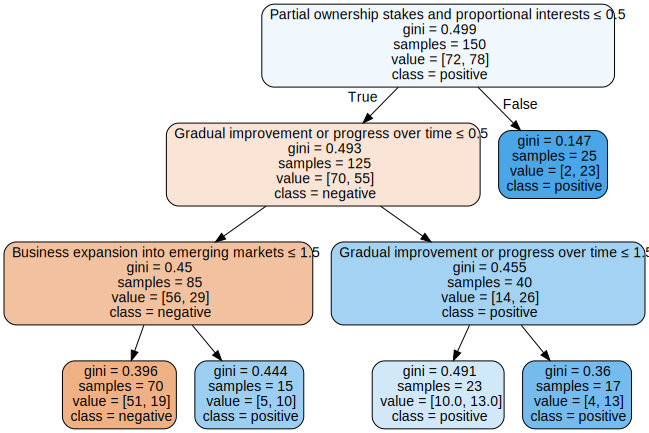

In [ ]:
# Let's visualize the tree

import graphviz


dot_data = tree.export_graphviz(
    best_tree,
    out_file=None,
    feature_names=[feature.label for feature in best_features],
    class_names=["negative", "positive"],
    filled=True,
    rounded=True,
    special_characters=True,
)
graph = graphviz.Source(dot_data)
graph

Now we have an easy-to-train, interpretable, simple classifier using features! Further work can be done to more intelligently identify important features to use for a given classification task, and improve overall classifier performance.